In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from pathlib import Path

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-03-04/longbeach.csv")

In [3]:
df["intake_date"] = pd.to_datetime(df["intake_date"])
df["outcome_date"] = pd.to_datetime(df["outcome_date"])
df["diff_days"] = (df["outcome_date"] - df["intake_date"]) / np.timedelta64(1, "D")

In [4]:
adopted = df[df["outcome_type"]=="adoption"]

In [5]:
grouped_animal = (df.groupby(["animal_type"])["animal_type"]
                  .value_counts()
                  .reset_index()
                  .sort_values(by=["count"], ascending=False, ignore_index=True))

In [6]:
adopted_animal = adopted.groupby(["animal_type"]).agg({'animal_type' : ['count'], 'diff_days' : ['mean']}).round(1)

In [7]:
adopted_animal = adopted_animal.reset_index()

In [8]:
adopted_animal.columns = ["animal_type", "adopted_count", "mean_days"]

In [9]:
merged = pd.merge(grouped_animal, adopted_animal, on="animal_type", how="inner")

In [10]:
merged["ratio"] =((merged["adopted_count"] / merged["count"])*100).round().astype(int)

In [11]:
a_list = ["other", "livestock"]

In [12]:
merged = merged[~merged["animal_type"].isin(a_list)]

In [13]:
merged = merged.sort_values(by=["ratio"], ascending=False)

In [14]:
animals = merged["animal_type"].unique()

In [15]:
X = np.repeat(np.arange(1,11), 10)
Y = np.tile(np.arange(1,11), 10)

In [16]:
merged["color"] = "#25c0de"
dot_color = "white"
dot_colors = []
for color, pct in zip(merged["color"], merged["ratio"]):
    dot_colors.append([color] * int(pct) + [dot_color] * (100 - int(pct)))

In [17]:
img_paths = list(Path("animals").glob("*.png"))
images_list = {img.stem: str(img) for img in img_paths}

In [18]:
keys = list(images_list.keys()) 
values = list(images_list.values())

In [19]:
keys

['bird', 'cat', 'reptile', 'pig', 'rabbit', 'dog']

In [20]:
keys[3] = "guinea " + keys[3]

In [21]:
images_list = dict(zip(keys, values))

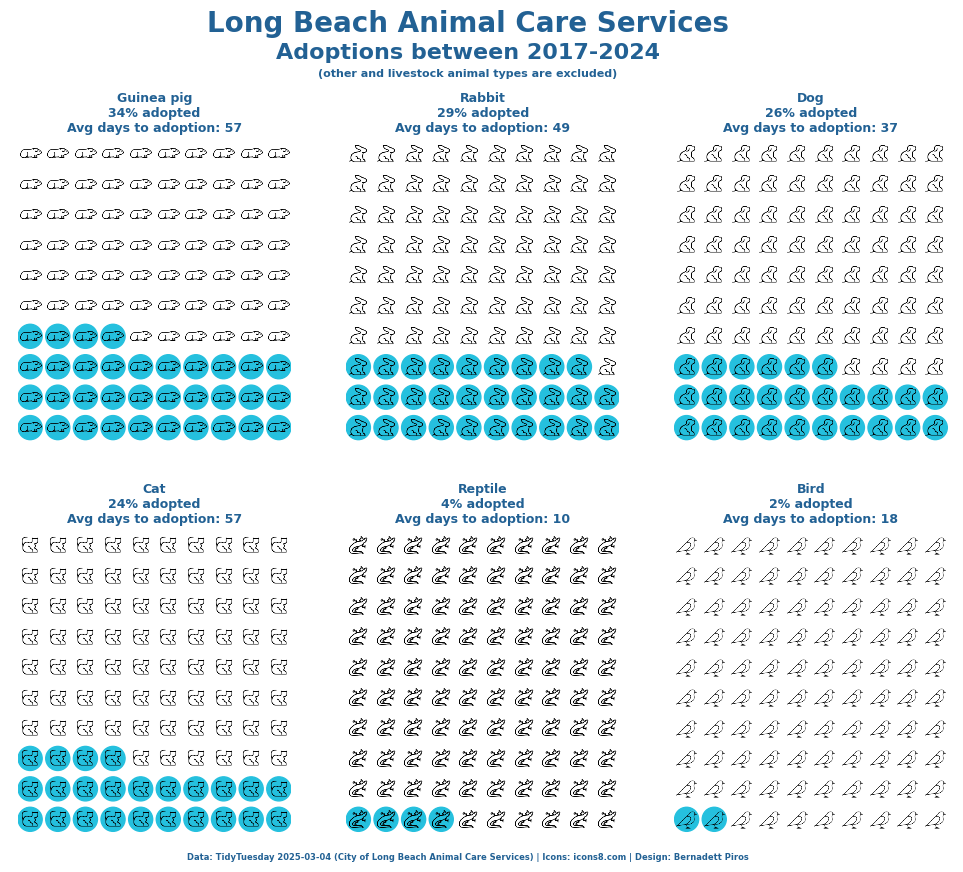

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3)

for ax, pct, mean_day, animal, dot_color in zip(axs.flat, merged["ratio"], merged["mean_days"], animals, dot_colors):
    ax.scatter(Y, X, c=dot_color,s=300)    
    
    if animal in images_list:  
        icon = mpimg.imread(images_list[animal])  
        
        # Overlay images as markers
        for x, y in zip(X, Y):
            imagebox = OffsetImage(icon, zoom=0.3)  
            ab = AnnotationBbox(imagebox, (y, x), frameon=False)
            ax.add_artist(ab)

            txt = (
                f"{animal.capitalize()}\n"
                f"{pct:.0f}% adopted\n"
                f"Avg days to adoption: {mean_day:.0f}"                
            )

            ax.set_title(txt, size=9, weight="bold", color="#226194")

            ax.axis("off")                 

fig.text(0.5, 1, "Long Beach Animal Care Services", size=20, color="#226194", weight="bold", ha="center")
fig.text(0.5, 0.97, "Adoptions between 2017-2024", size=16, color="#226194", weight="bold", ha="center")
fig.text(0.5, 0.95, "(other and livestock animal types are excluded)", size=8, color="#226194", weight="bold", ha="center")
fig.text(0.5, 0.08, "Data: TidyTuesday 2025-03-04 (City of Long Beach Animal Care Services) | Icons: icons8.com | Design: Bernadett Piros", color="#226194", size=6, weight="bold", ha="center")

plt.show()

#plt.savefig("2025-03-04", dpi=300, bbox_inches='tight', pad_inches=0.2)